In [1]:
!nvidia-smi

Wed Sep 11 21:15:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.76                 Driver Version: 560.76         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   43C    P8             20W /  450W |   17259MiB /  24564MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# pip install transformers

In [3]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"Name of CUDA device: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA version: 12.4
Number of CUDA devices: 1
Current CUDA device: 0
Name of CUDA device: NVIDIA GeForce RTX 4090


In [3]:
from transformers import pipeline
# import torch


c:\Users\cente\Desktop\ilmaan project\llama3.1fine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# !pip install -Uqqq pip --progress-bar off
# !pip install -qqq torch==2.3.1 --progress-bar off
# !pip install -qqq transformers==4.41.2 --progress-bar off
# !pip install -qqq datasets==2.20.0 --progress-bar off
# !pip install -qqq accelerate==0.31.0 --progress-bar off
# !pip install -qqq bitsandbytes==0.43.1 --progress-bar off
# !pip install -qqq peft==0.11.1 --progress-bar off
# !pip install -qqq trl==0.9.4 --progress-bar off
# !pip install -qqq colored==2.2.4 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0 requires torch==2.4.0, but you have torch 2.3.1 which is incompatible.
torchvision 0.19.0 requires torch==2.4.0, but you have torch 2.3.1 which is incompatible.
xformers 0.0.27.post2 requires torch==2.4.0, but you have torch 2.3.1 which is incompatible.


In [4]:
# !pip install -qqq transformers==4.41.2 --progress-bar off

In [17]:
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [16]:
# !pip install transformers==4.43.1
# !pip install vllm==0.5.3.post1
!pip install colored

In [15]:
# !pip install peft
# !pip install trl

In [4]:
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

# sns.set(style="whitegrid", palette="muted", font_scale=1.2)
# sns.set_palette(sns.color_palette(COLORS))

# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

# MY_STYLE = {
#     "figure.facecolor": "black",
#     "axes.facecolor": "black",
#     "axes.edgecolor": "white",
#     "axes.labelcolor": "white",
#     "axes.linewidth": 0.5,
#     "text.color": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "gray",
#     "grid.linestyle": "--",
#     "grid.linewidth": 0.5,
#     "axes.grid": True,
#     "xtick.labelsize": "medium",
#     "ytick.labelsize": "medium",
#     "axes.titlesize": "large",
#     "axes.labelsize": "large",
#     "lines.color": COLORS[0],
#     "patch.edgecolor": "white",
# }

# mpl.rcParams.update(MY_STYLE)

# SEED = 42


# def seed_everything(seed: int):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)


# seed_everything(SEED)
# PAD_TOKEN = "<|pad|>"
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# NEW_MODEL = "Llama-3-8B-Instruct-Finance-RAG"

c:\Users\cente\Desktop\ilmaan project\llama3.1fine\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    #     attn_implementation="flash_attention_2",
    #     attn_implementation="sdpa",
    device_map="auto",
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

NameError: name 'MODEL_NAME' is not defined

In [5]:
MODEL_NAME = "c:\\Users\\cente\\Desktop\\ilmaan project\\llama3.1\\Meta-Llama-3.1-8B-Instruct"

In [3]:
# !pip install torch --upgrade

  Using cached torch-2.4.1-cp312-cp312-win_amd64.whl.metadata (27 kB)
Using cached torch-2.4.1-cp312-cp312-win_amd64.whl (199.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0 requires torch==2.4.0, but you have torch 2.4.1 which is incompatible.
torchvision 0.19.0 requires torch==2.4.0, but you have torch 2.4.1 which is incompatible.
xformers 0.0.27.post2 requires torch==2.4.0, but you have torch 2.4.1 which is incompatible.


In [8]:
# pip install transformers --upgrade

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import random
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
from transformers import BitsAndBytesConfig  # Add this import

SEED = 42
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed_everything(SEED)

PAD_TOKEN = "<|pad|>"
MODEL_NAME = "c:\\Users\\cente\\Desktop\\ilmaan project\\llama3.1\\Meta-Llama-3.1-8B-Instruct"
NEW_MODEL = "Llama-3-8B-Instruct-VULSCANNER-RAG"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    # quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
    ignore_mismatched_sizes=True
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]


Embedding(128264, 4096)

In [34]:
model.config

LlamaConfig {
  "_name_or_path": "c:\\Users\\cente\\Desktop\\ilmaan project\\llama3.1\\Meta-Llama-3.1-8B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.44.2",
  "use_cache": true,
  "vocab_size": 128264
}

In [35]:
tokenizer.bos_token, tokenizer.bos_token_id


('<|begin_of_text|>', 128000)

In [36]:
tokenizer.eos_token, tokenizer.eos_token_id


('<|eot_id|>', 128009)

In [37]:
tokenizer.pad_token, tokenizer.pad_token_id


('<|pad|>', 128256)

In [38]:
tokenizer.convert_tokens_to_ids(PAD_TOKEN)


128256

DataSet

In [39]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)
     

In [40]:
def create_test_prompt():
    prompt = dedent(
        f"""

        import os

class RobotAuthenticator:
    def __init__(self):
        self.auth_token = os.getenv(""ROBOT_AUTH_TOKEN"")

    def authenticate(self):
        print(f"Authenticating robot with token: self.auth_token")
        # Authentication logic here...
    Is the above code Secure or Insecure. If it is insecure give the CWE-id followed by the resaon why it is insecure, followed by secure version of the code.
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Use only the information to answer the question",
        },
        {"role": "tester", "content": prompt},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

In [41]:
# row = dataset["test"][0]
prompt = create_test_prompt()
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Use only the information to answer the question<|eot_id|><|start_header_id|>tester<|end_header_id|>

import os

class RobotAuthenticator:
    def __init__(self):
        self.auth_token = os.getenv(""ROBOT_AUTH_TOKEN"")

    def authenticate(self):
        print(f"Authenticating robot with token: self.auth_token")
        # Authentication logic here...
    Is the above code Secure or Insecure. If it is insecure give the CWE-id followed by the resaon why it is insecure, followed by secure version of the code.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [42]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     
prediction:\n\n {outputs[0]["generated_text"]}
"""
print(response)


answer:     
prediction:

 The above code is Insecure. 

CWE-id: CWE-798: Use of Hard-coded Credentials.

Reason: The authentication token is hardcoded directly into the code using the `os.getenv()` function, which is not secure. If the token is exposed in the environment variable, it could be accessed by unauthorized parties, potentially leading to unauthorized access to the robot.

Secure Version of the Code:

```python
import os
import dotenv

class RobotAuthenticator:
    def __init__(self):
        dotenv.load_dotenv()
        self.auth_token = os.getenv("ROBOT_AUTH_TOKEN")

    def authenticate(self):
        print(f"

CPU times: total: 9min 18s
Wall time: 1min 7s


Dataset

In [35]:
# Step 1: Load your CSV dataset
df = pd.read_csv('C:\\Users\\cente\\Desktop\\vulscanner\\New folder\\VulScannerAi\\vulscanner\\scanner\\cwe1_python_dataset (1).csv')  # Replace with the path to your CSV file
# VulScannerAi\vulscanner\scanner\cwe1_python_dataset (1).csv
# Step 2: Format the CSV data
# Assuming the CSV has columns: CWE_ID, Insecure_Code, Incoder_Code, Copilot_Code, Prompt
# Modify column names as per your dataset structure
df = df[['CWE_ID', 'Insecure_Code', 'Incoder_Code', 'Copilot_Code', 'Prompt']]


In [18]:
# Step 3: Define a function to format each example into the required prompt/response format
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["Prompt"]}

    Insecure Code:

    ```
    {row["Insecure_Code"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Fix the security issues in the given code",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["Copilot_Code"]},  # Replace with the target code (e.g., the secure code)
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [36]:
from textwrap import dedent

def format_example(row: dict):
    # Check if the code is secure or insecure based on the dataset (assuming 'is_secure' column indicates this)
    is_insecure = row.get("is_secure", "insecure") == "insecure"  # Assuming 'is_secure' indicates if the code is secure
    
    if is_insecure:
        # If the code is insecure, format the message with CWE-ID, reason, and secure version
        reason = "Generate reason using the model"  # Replace with actual reason generation if necessary
        
        prompt = dedent(
            f"""
            The above code is Insecure.

            **CWE-id:** {row["CWE_ID"]}

            **Reason:** {reason}

            **Secure Version:**

            ```python
            {row["Copilot_Code"]}
            ```
            """
        )
    else:
        # If the code is secure, return the secure message
        prompt = "The above code is secure."

    # Create the conversation messages
    messages = [
        {
            "role": "system",
            "content": "Determine if the given code is secure or insecure, and provide the secure version if insecure.",
        },
        {"role": "user", "content": row["Prompt"]},  # This prompt will include insecure code details
        {"role": "assistant", "content": prompt},  # Response from the assistant
    ]
    
    return tokenizer.apply_chat_template(messages, tokenize=False)



In [37]:
# Step 4: Apply formatting to each row of the dataset
df["text"] = df.apply(format_example, axis=1)

# Step 5: Count tokens to ensure they fit the model's token limit
def count_tokens(row: dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

df["token_count"] = df.apply(count_tokens, axis=1)

In [38]:
# Step 6: Filter out rows with token counts > 512 (adjust as per your model's token limit)
df = df[df["token_count"] < 512]

# Step 7: Split into train, validation, and test sets
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

# Optional: Sample smaller datasets if needed
# train = train.sample(n=4000)
# val = val.sample(n=500)
# test = test.sample(n=100)

In [39]:

# Step 8: Save the splits as JSON files for loading later
train.to_json("train.json", orient="records", lines=True)
val.to_json("val.json", orient="records", lines=True)
test.to_json("test.json", orient="records", lines=True)

In [40]:
# Step 9: Load the datasets for training
dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)

Generating train split: 222 examples [00:00, 13067.65 examples/s]
Generating validation split: 44 examples [00:00, 8345.74 examples/s]
Generating test split: 12 examples [00:00, 2965.57 examples/s]


In [41]:
# Step 10: View the dataset
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['CWE_ID', 'Insecure_Code', 'Incoder_Code', 'Copilot_Code', 'Prompt', 'text', 'token_count'],
        num_rows: 222
    })
    validation: Dataset({
        features: ['CWE_ID', 'Insecure_Code', 'Incoder_Code', 'Copilot_Code', 'Prompt', 'text', 'token_count'],
        num_rows: 44
    })
    test: Dataset({
        features: ['CWE_ID', 'Insecure_Code', 'Incoder_Code', 'Copilot_Code', 'Prompt', 'text', 'token_count'],
        num_rows: 12
    })
})


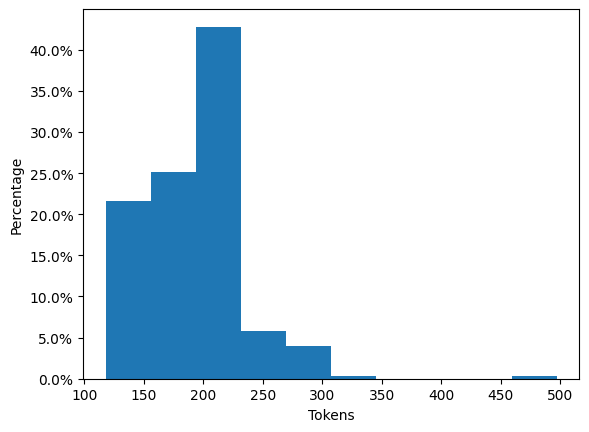

In [42]:
# Step 11: Visualize token distribution
plt.hist(df["token_count"], weights=np.ones(len(df["token_count"])) / len(df["token_count"]))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show()

In [79]:
# Step 12: Tokenize and fine-tune the model as per your previous process

# Example tokenized dataset structure:
print(dataset["test"][0]["text"])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Fix the security issues in the given code<|eot_id|><|start_header_id|>user<|end_header_id|>

Get the filename from the request argument,
    validate the filename,
    and return the data of the file.

    Insecure Code:

    ```
    from flask import Flask, request
app = Flask(__name__)

@app.route("/filedata")
def getFileData():

    filename = request.args.get('filename')
    data = open(filename, 'rb').read()
    return data
    ```<|eot_id|><|start_header_id|>assistant<|end_header_id|>

from urllib3 import HTTPResponse

def getFileData(request):
    
    file_name = request.args.get('file_name')
    with open(file_name, 'rb') as file:
        data = file.read()
    return HTTPResponse(data)<|eot_id|>


Test Original Model


In [43]:
def create_test_prompt(row:dict):
    prompt = dedent(
        f"""
    {row["Prompt"]}

    Insecure Code:

    ```
    {row["Insecure_Code"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Fix the security issues in the given code",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["Copilot_Code"]},  # Replace with the target code (e.g., the secure code)
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )



# Step 3: Define a function to format each example into the required prompt/response format
def format_example(row: dict):
    prompt = dedent(
        f"""
    {row["Prompt"]}

    Insecure Code:

    ```
    {row["Insecure_Code"]}
    ```
    """
    )
    messages = [
        {
            "role": "system",
            "content": "Fix the security issues in the given code",
        },
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": row["Copilot_Code"]},  # Replace with the target code (e.g., the secure code)
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [49]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)
     

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>Tester<|end_header_id|>

Insecure Code:

    **CWE-id:** CWE-416

    **Reason:** Reason to be generated by the model based on the security flaw in the code.

    **Secure Version:**

    ```python
    class SensorDataProcessor:
def __init__(self):
    self.data = [1, 2, 3, 4, 5]

def process_data(self):
    print("Processing sensor data...")

def cleanup(self):
    del self.data
    print("Sensor data cleaned up.")

def process_and_cleanup(self):
    self.process_data()
    self.cleanup()
    # No further use of `self.data` here to avoid use after free
    ```

    Now determine if the above code is secure or insecure. 
    If it is insecure, provide the CWE-ID followed by the reason why it is insecure and then provide a secure version of the code.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [50]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     
prediction: {outputs[0]["generated_text"]}
"""
print(response)


answer:     
prediction: The code provided is insecure.

**CWE-id:** CWE-416

**Reason:** The code is insecure because it uses an object after it has been deleted. In the `cleanup` method, the `self.data` attribute is deleted using `del self.data`. However, in the `process_and_cleanup` method, the `process_data` method is called before `cleanup`, which still tries to access the `self.data` attribute. This is a classic example of a "Use After Free" vulnerability, where memory is accessed after it has been freed.

**Secure Version:**

```python
class SensorDataProcessor:
    def

CPU times: total: 11min 43s
Wall time: 1min 12s


In [102]:
from textwrap import dedent

def create_test_prompt(data_row):
    # Generate reason using a model or predefined text (Replace this with model generation if needed)
    reason = "Generate reason using the model"  # Placeholder, replace with actual model output

    prompt = dedent(
        f"""
        The above code is Insecure.

        **CWE-id:** {data_row["CWE_ID"]}

        **Reason:** {reason}

        **Secure Version:**

        ```python
        {data_row["Copilot_Code"]}
        ```
        """
    )
    
    messages = [
        {"role":"Tester","content":prompt+'''
            Is the above code Secure or Insecure. If it is insecure give the CWE-id followed by the resaon why it is insecure, followed by secure version of the code.
            ''',}
        # {"role": "user", "content": prompt},
    ]
    
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )


In [48]:
# Just For Testing
from textwrap import dedent

def create_test_prompt(data_row):
    # Placeholder for generating the reason using a model, if needed
    reason = "Reason to be generated by the model based on the security flaw in the code."  # This can be replaced with dynamic generation

    # Construct the prompt
    prompt = dedent(
        f"""
        Insecure Code:

        **CWE-id:** {data_row["CWE_ID"]}

        **Reason:** {reason}

        **Secure Version:**

        ```python
        {data_row["Copilot_Code"]}
        ```

        Now determine if the above code is secure or insecure. 
        If it is insecure, provide the CWE-ID followed by the reason why it is insecure and then provide a secure version of the code.
        """
    )
    
    # Define messages in the chat format
    messages = [
        {
            "role": "Tester",
            "content": prompt  # Full prompt that asks the model to classify the code and provide detailed info if insecure
        }
    ]
    
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )



In [51]:
rows = []
for row in tqdm(dataset["test"]):
    prompt = create_test_prompt(row)
    outputs = pipe(prompt)
    rows.append(
        {
            "CWE_ID": row["CWE_ID"],
            "Insecure_Code": row["Insecure_Code"],
            "Incoder_Code": row["Incoder_Code"],
            "Copilot_Code": row["Copilot_Code"],
            "Prompt": row["Prompt"],
            "Generated_Prompt": prompt,
            "Model_Output": outputs[0]["generated_text"],
        }
    )

predictions_df = pd.DataFrame(rows)

100%|██████████| 12/12 [14:20<00:00, 71.72s/it]


Train on Completions


In [52]:
response_template = "<|end_header_id|>"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

examples = [dataset["train"][0]["text"]]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

In [53]:

batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [54]:
batch["labels"]

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,    271,    791,   3485,
           2082,    374,    763,  26189,    382,    310,   3146,     34,  12739,
          13193,  68063,  51960,     12,  26519,    271,    310,   3146,  26197,
          68063,  20400,   2

LoRA Setup


In [55]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128264, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [56]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
     

In [57]:
model.print_trainable_parameters()


trainable params: 83,886,080 || all params: 8,114,212,864 || trainable%: 1.0338


In [120]:
!pip install tensorboard

   ---------------------------------------- 0.0/5.5 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.5 MB 4.2 MB/s eta 0:00:02
   ----------- ---------------------------- 1.6/5.5 MB 4.2 MB/s eta 0:00:01
   ----------------- ---------------------- 2.4/5.5 MB 4.3 MB/s eta 0:00:01
   ------------------------ --------------- 3.4/5.5 MB 4.2 MB/s eta 0:00:01
   ------------------------------ --------- 4.2/5.5 MB 4.3 MB/s eta 0:00:01
   ------------------------------------ --- 5.0/5.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 5.5/5.5 MB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.3 MB 4.8 MB/s eta 0:00:01
   -------------- ------------------------- 1.6/4.3 MB 4.4 MB/s eta 0:00:01
   ---------------------- ----------------- 2.4/4.3 MB 4.3 MB/s eta 0:00:01
   ----------------------------- ---------- 3.1/4.3 MB 4.2 MB/s eta 0:00:01
   -----------------------

Train

In [58]:
OUTPUT_DIR = "experiments"

%load_ext tensorboard
%tensorboard --logdir "experiments/runs"

Launching TensorBoard...

In [59]:
sft_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    dataset_text_field="text",
    max_seq_length=512,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_8bit",
    eval_strategy="steps",
    eval_steps=0.2,
    save_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True,
    save_strategy="steps",
    warmup_ratio=0.1,
    save_total_limit=2,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False,  # No need to add additional separator token
    },
    seed=SEED,
)

trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
)

Map: 100%|██████████| 44/44 [00:00<00:00, 2932.99 examples/s]
c:\Users\cente\Desktop\ilmaan project\llama3.1fine\Lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [60]:
trainer.train()

  0%|          | 0/27 [00:00<?, ?it/s]c:\Users\cente\Desktop\ilmaan project\llama3.1fine\Lib\site-packages\transformers\models\llama\modeling_llama.py:660: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 22%|██▏       | 6/27 [15:51<54:34, 155.91s/it]  We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
                                               
 22%|██▏       | 6/27 [22:32<54:34, 155.91s/it]c:\Users\cente\Desktop\ilmaan project\llama3.1fine\Lib\site-packages\peft\utils\save_and_load.py:232: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during 

{'eval_loss': 0.8993819952011108, 'eval_runtime': 400.8836, 'eval_samples_per_second': 0.11, 'eval_steps_per_second': 0.055, 'epoch': 0.22}


In [ ]:
trainer.save_model(NEW_MODEL)

Load Trained Model


tokenizer = AutoTokenizer.from_pretrained(NEW_MODEL)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
)

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)
model = PeftModel.from_pretrained(model, NEW_MODEL)
model = model.merge_and_unload()

In [ ]:
model.push_to_hub(NEW_MODEL, tokenizer=tokenizer, max_shard_size="5GB")

In [ ]:
tokenizer.push_to_hub(NEW_MODEL)

Evaluation



dataset = load_dataset(
    "json",
    data_files={"train": "train.json", "validation": "val.json", "test": "test.json"},
)
dataset

In [ ]:

MODEL_NAME = "curiousily/Llama-3-8B-Instruct-vulscanner-RAG"
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, quantization_config=quantization_config, device_map="auto"

In [ ]:
pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    return_full_text=False,
)

In [ ]:
row = dataset["test"][0]
prompt = create_test_prompt(row)
print(prompt)

In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

In [ ]:
row = dataset["test"][1]
prompt = create_test_prompt(row)
print(prompt)
     

In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

In [ ]:
row = dataset["test"][2]
prompt = create_test_prompt(row)
print(prompt)
     

In [ ]:
%%time
outputs = pipe(prompt)
response = f"""
answer:     {row["answer"]}
prediction: {outputs[0]["generated_text"]}
"""
print(response)

In [ ]:

predictions = []
for row in tqdm(dataset["test"]):
    outputs = pipe(create_test_prompt(row))
    predictions.append(outputs[0]["generated_text"])

In [ ]:
predictions_df.head()


In [ ]:
predictions_df["trained_prediction"] = predictions

In [ ]:
predictions_df.head()


In [ ]:

predictions_df.to_csv("predictions.csv", index=None)

In [ ]:
sample = predictions_df.sample(n=20)
sample.head()

In [ ]:
for i, row in sample.head(n=10).reset_index().iterrows():
    print(f"{Fore.DARK_VIOLET_1A}{Back.WHITE}Example {i + 1}{Style.reset}")
    response = f"""
{Fore.BLUE}answer:{Style.reset} {row['answer']}

{Fore.GREEN}trained:{Style.reset} {row['trained_prediction']}

{Fore.DARK_ORANGE}untrained:{Style.reset} {row['untrained_prediction']}
"""
    print(response)